In [1]:
# Script for training a DeepMass inference model
import os

os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/gpfslocalsys/cuda/10.1.2'

from absl import app
from absl import flags

import haiku as hk
import jax
import jax.numpy as jnp
from jax.experimental import optix

import numpy as onp
import pickle
from functools import partial
from astropy.io import fits

from flax.metrics import tensorboard

# Import tensorflow for dataset creation and manipulation
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_datasets as tfds

from jax_lensing.models.convdae import SmallUResNet
from jax_lensing.models.convdae2 import MediumUResNet
from jax_lensing.models.normalization import SNParamsTree as CustomSNParamsTree
from jax_lensing.spectral import make_power_map
from jax_lensing.utils import load_dataset_deepmass
from jax_lensing.inversion import ks93, ks93inv

In [2]:
model_v = 'SmallUResNet'
variant = 'EiffL'
batch_size = 28
weight_dir = '../scripts/weights/deepmass-sn0v3'
mask_path = '../data/COSMOS/cosmos_full_mask_0.29arcmin360copy.fits'
train_split = "90%"
map_size = 360
dataset = 'kappatng'
sigma_gamma = 0.148

In [3]:
def forward_fn(x, is_training=False):
  if model_v == 'SmallUResNet':
    model = SmallUResNet(n_output_channels=1, variant=variant, deepmass=True)
  return model(x, jnp.zeros((1, 1, 1, 1)), is_training=is_training)

ks93 = jax.vmap(ks93)
ks93inv = jax.vmap(ks93inv)

In [4]:
# import trained model weights
model_name = "model-final.pckl"

with open(weight_dir+'/'+ model_name, 'rb') as file: 
    [params, state, sn_state] = pickle.load(file)

In [5]:
# Make the network
model = hk.transform_with_state(forward_fn)

In [6]:
mask = jnp.expand_dims(fits.getdata(mask_path).astype('float32'), 0) # has shape [1, FLAGS.map_size,FLAGS.map_size]

## DeepMass on the validation map

In [7]:
%pylab inline

convergence = fits.getdata('../data/ktng/ktng_kappa360v2.fits').astype(np.float32).reshape(1,360,360)
std1 = jnp.expand_dims(jnp.load('../data/COSMOS/std1.npy').astype('float32'), 0)
std2 = jnp.expand_dims(jnp.load('../data/COSMOS/std2.npy').astype('float32'), 0)

input_map = convergence
g1o, g2o = ks93inv(input_map, jnp.zeros_like(input_map))

Populating the interactive namespace from numpy and matplotlib


In [8]:
rng_seq = hk.PRNGSequence(42)
rng_key = next(rng_seq)
key1, key2, key3, key4 ,key5 = jax.random.split(rng_key, 5)

In [9]:
# same noised std on pixels

g1 = mask * (g1o + .148*jax.random.normal(key1, g1o.shape)) 
g2 = mask * (g2o + .148*jax.random.normal(key2, g2o.shape))

In [10]:
# pixel dependent noise std

g1_ng = mask * (g1o + std1*jax.random.normal(key3, g1.shape))
g2_ng = mask * (g2o + std2*jax.random.normal(key4, g2.shape))

g1 = jnp.concatenate([g1, g1_ng], axis=0)
g2 = jnp.concatenate([g2, g2_ng], axis=0)

Text(0.5,1,'e2')

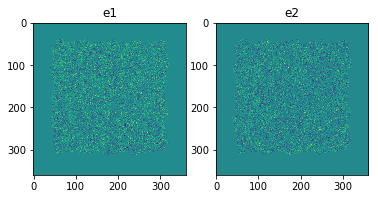

In [11]:
# input shear
subplot(121)
imshow(g1[0,...])
title('e1')
subplot(122)
imshow(g2[0,...])
title('e2')

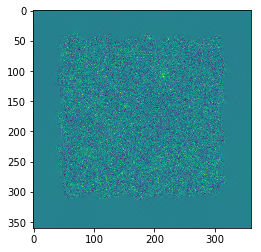

In [12]:
# KS before the neural network
ks_map, _ = ks93(g1, g2)
ks_map = jnp.expand_dims(ks_map,-1)
imshow(ks_map[0,...,0])

In [13]:
res, state = model.apply(params, state, key5, ks_map, is_training=False)

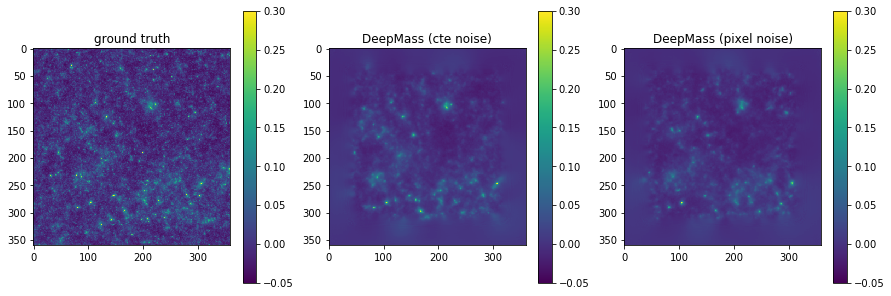

In [14]:
kwargs = dict(vmin=-.05, vmax=0.3)

figure(figsize=(15,5))
subplot(131)
imshow(convergence[0,...], **kwargs)
title('ground truth')
colorbar()
subplot(132)
imshow(res[0,...,0], **kwargs)
title('DeepMass (cte noise)')
colorbar()
subplot(133)
imshow(res[1,...,0], **kwargs)
title('DeepMass (pixel noise)')
colorbar()

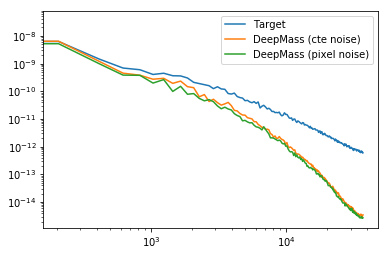

In [15]:
from jax_lensing.spectral import measure_power_spectrum

resolution = .29
pixel_size = jnp.pi * resolution / 180. / 60. #rad/pixel

ell_c, power_spectrum_1d_c = measure_power_spectrum(convergence[0,...], pixel_size)
ell_d, power_spectrum_1d_d = measure_power_spectrum(res[0,...,0], pixel_size)
ell_p, power_spectrum_1d_p = measure_power_spectrum(res[1,...,0], pixel_size)

loglog(ell_c, power_spectrum_1d_c, label='Target')
loglog(ell_d, power_spectrum_1d_d, label='DeepMass (cte noise)')
loglog(ell_p, power_spectrum_1d_p, label='DeepMass (pixel noise)')

legend()